# Steps for training detectron2 on custom data

### Loading necessary libraries

In [2]:
import h5py
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
import time
%config Completer.use_jedi = False


os.chdir("C:/Users/admin/Documents/Python Scripts/Soma-Segmentation/train")
from utils import ImageJ2COCO
from config import configuration
from segmentation_predictor import predict_img


#from train import run_train
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog

import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultPredictor

### Registering data

In [3]:
# if data already is in COCO style
register_coco_instances("train", {}, "I:/Sina/Medical report segmentation/publaynet/val.json", 
                        "I:/Sina/Medical report segmentation/publaynet/val")
register_coco_instances("val", {}, "I:/Sina/Medical report segmentation/publaynet/val.json", 
                        "I:/Sina/Medical report segmentation/publaynet/val")


#MetadataCatalog.get("val").set(thing_classes=["title", "text", "figure", "table", "list"])
#MetadataCatalog.get("train").set(thing_classes=["title", "text", "figure", "table", "list"])

In [2]:
# for custom data with custom written dataloader

# dataloader for train dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_train = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[10000, 12000], 
                           end_index=[12000, 14000], 
                           image_nr=[1400, 1500], 
                           id_starter=[1, 2000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# dataloader for validation dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_val = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[1000, 1200], 
                           end_index=[20000, 40000], 
                           image_nr=[800, 800], 
                           id_starter=[3000, 4000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# register train data set
DatasetCatalog.register("train", img2coco_train.transform)
MetadataCatalog.get("train").set(thing_classes=["soma"]) # define classes as well

# register validation data set
DatasetCatalog.register("val", img2coco_val.transform)
MetadataCatalog.get("val").set(thing_classes=["soma"]) # define classes as well

metadata = MetadataCatalog.get("train")

### Check visually the data load step

In [3]:
# prepare data

mydata = DatasetCatalog.get("train")
mydata_metdata = MetadataCatalog.get("train")

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 434.08it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:14<00:00, 285.15it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:02<00:00, 566.22it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:18<00:00, 213.38it/s]


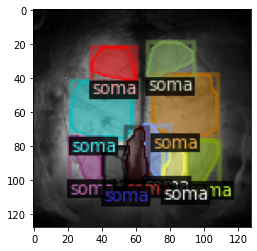

In [5]:
# plot
%matplotlib inline

for d in random.sample(mydata, 1):    
    im = cv2.imread(d["file_name"])
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydata_metdata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Model configuration

In [4]:
# configuration file
cfg = configuration(num_classes=5,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=1500, 
                    base_lr = 0.001,
                    model_weights=False, #"C:/Users/admin/Desktop/test/out/model_final.pth", # if you have another weights give that one
                    validation=True) # if you have validation turn it to True

### Model training

#### Default params

In [7]:
# start training

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/12 16:44:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 448.26it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:12<00:00, 329.36it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:03<00:00, 491.45it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:14<00:00, 269.26it/s]

[10/12 16:45:10 d2.data.build]: Removed 0 images with no usable annotations. 8000 images left.


[10/12 16:45:10 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    soma    | 80000        |
|            |              |
[10/12 16:45:10 d2.data.common]: Serializing 8000 elements to byte tensors and concatenating them all ...
[10/12 16:45:11 d2.data.common]: Serialized dataset takes 33.11 MiB
[10/12 16:45:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125,), max_size=1333, sample_style='choice'), RandomFlip()]
[10/12 16:45:11 d2.data.build]: Using training sampler TrainingSampler


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/12 16:45:12 d2.engine.train_loop]: Starting training from iteration 0


c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/12 16:45:26 d2.utils.events]:  eta: 1:06:56  iter: 19  total_loss: 4.601  loss_cls: 0.703  loss_box_reg: 0.286  loss_mask: 0.685  loss_rpn_cls: 2.677  loss_rpn_loc: 0.375  time: 0.2677  data_time: 0.3076  lr: 0.000020  max_mem: 850M
[10/12 16:45:31 d2.utils.events]:  eta: 1:08:18  iter: 39  total_loss: 2.534  loss_cls: 0.456  loss_box_reg: 0.504  loss_mask: 0.677  loss_rpn_cls: 0.626  loss_rpn_loc: 0.258  time: 0.2698  data_time: 0.0036  lr: 0.000040  max_mem: 875M
[10/12 16:45:37 d2.utils.events]:  eta: 1:07:24  iter: 59  total_loss: 1.949  loss_cls: 0.349  loss_box_reg: 0.366  loss_mask: 0.659  loss_rpn_cls: 0.300  loss_rpn_loc: 0.224  time: 0.2702  data_time: 0.0032  lr: 0.000060  max_mem: 875M
[10/12 16:45:43 d2.utils.events]:  eta: 1:07:23  iter: 79  total_loss: 1.846  loss_cls: 0.352  loss_box_reg: 0.394  loss_mask: 0.644  loss_rpn_cls: 0.215  loss_rpn_loc: 0.191  time: 0.2707  data_time: 0.0039  lr: 0.000080  max_mem: 875M
[10/12 16:45:48 d2.utils.events]:  eta: 1:07:53  ite

[10/12 16:48:45 d2.utils.events]:  eta: 1:10:08  iter: 699  total_loss: 0.477  loss_cls: 0.084  loss_box_reg: 0.162  loss_mask: 0.126  loss_rpn_cls: 0.014  loss_rpn_loc: 0.085  time: 0.2898  data_time: 0.0030  lr: 0.000699  max_mem: 1072M
[10/12 16:48:51 d2.utils.events]:  eta: 1:10:07  iter: 719  total_loss: 0.433  loss_cls: 0.083  loss_box_reg: 0.141  loss_mask: 0.116  loss_rpn_cls: 0.012  loss_rpn_loc: 0.085  time: 0.2901  data_time: 0.0021  lr: 0.000719  max_mem: 1072M
[10/12 16:48:57 d2.utils.events]:  eta: 1:10:06  iter: 739  total_loss: 0.397  loss_cls: 0.075  loss_box_reg: 0.135  loss_mask: 0.113  loss_rpn_cls: 0.008  loss_rpn_loc: 0.062  time: 0.2903  data_time: 0.0019  lr: 0.000739  max_mem: 1072M
[10/12 16:49:03 d2.utils.events]:  eta: 1:10:01  iter: 759  total_loss: 0.454  loss_cls: 0.073  loss_box_reg: 0.160  loss_mask: 0.112  loss_rpn_cls: 0.007  loss_rpn_loc: 0.062  time: 0.2904  data_time: 0.0025  lr: 0.000759  max_mem: 1072M
[10/12 16:49:09 d2.utils.events]:  eta: 1:09

[10/12 16:52:02 d2.utils.events]:  eta: 1:07:48  iter: 1359  total_loss: 0.242  loss_cls: 0.039  loss_box_reg: 0.074  loss_mask: 0.073  loss_rpn_cls: 0.006  loss_rpn_loc: 0.040  time: 0.2927  data_time: 0.0070  lr: 0.001000  max_mem: 1072M
[10/12 16:52:08 d2.utils.events]:  eta: 1:07:46  iter: 1379  total_loss: 0.270  loss_cls: 0.040  loss_box_reg: 0.079  loss_mask: 0.080  loss_rpn_cls: 0.006  loss_rpn_loc: 0.050  time: 0.2928  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 16:52:14 d2.utils.events]:  eta: 1:07:42  iter: 1399  total_loss: 0.234  loss_cls: 0.040  loss_box_reg: 0.075  loss_mask: 0.075  loss_rpn_cls: 0.005  loss_rpn_loc: 0.034  time: 0.2930  data_time: 0.0068  lr: 0.001000  max_mem: 1072M
[10/12 16:52:20 d2.utils.events]:  eta: 1:07:38  iter: 1419  total_loss: 0.244  loss_cls: 0.038  loss_box_reg: 0.078  loss_mask: 0.072  loss_rpn_cls: 0.005  loss_rpn_loc: 0.039  time: 0.2932  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 16:52:26 d2.utils.events]:  eta: 

[10/12 16:55:19 d2.utils.events]:  eta: 1:04:35  iter: 2019  total_loss: 0.216  loss_cls: 0.028  loss_box_reg: 0.065  loss_mask: 0.065  loss_rpn_cls: 0.004  loss_rpn_loc: 0.048  time: 0.2941  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:55:25 d2.utils.events]:  eta: 1:04:30  iter: 2039  total_loss: 0.205  loss_cls: 0.030  loss_box_reg: 0.066  loss_mask: 0.060  loss_rpn_cls: 0.003  loss_rpn_loc: 0.034  time: 0.2941  data_time: 0.0014  lr: 0.001000  max_mem: 1072M
[10/12 16:55:31 d2.utils.events]:  eta: 1:04:24  iter: 2059  total_loss: 0.265  loss_cls: 0.027  loss_box_reg: 0.077  loss_mask: 0.069  loss_rpn_cls: 0.004  loss_rpn_loc: 0.059  time: 0.2940  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 16:55:37 d2.utils.events]:  eta: 1:04:17  iter: 2079  total_loss: 0.220  loss_cls: 0.033  loss_box_reg: 0.065  loss_mask: 0.058  loss_rpn_cls: 0.005  loss_rpn_loc: 0.047  time: 0.2940  data_time: 0.0013  lr: 0.001000  max_mem: 1072M
[10/12 16:55:43 d2.utils.events]:  eta: 

[10/12 16:58:36 d2.utils.events]:  eta: 1:01:03  iter: 2679  total_loss: 0.263  loss_cls: 0.019  loss_box_reg: 0.053  loss_mask: 0.103  loss_rpn_cls: 0.005  loss_rpn_loc: 0.067  time: 0.2942  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:58:42 d2.utils.events]:  eta: 1:00:58  iter: 2699  total_loss: 0.173  loss_cls: 0.028  loss_box_reg: 0.048  loss_mask: 0.052  loss_rpn_cls: 0.003  loss_rpn_loc: 0.028  time: 0.2942  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 16:58:48 d2.utils.events]:  eta: 1:00:52  iter: 2719  total_loss: 0.180  loss_cls: 0.027  loss_box_reg: 0.053  loss_mask: 0.053  loss_rpn_cls: 0.003  loss_rpn_loc: 0.039  time: 0.2942  data_time: 0.0007  lr: 0.001000  max_mem: 1072M
[10/12 16:58:54 d2.utils.events]:  eta: 1:00:46  iter: 2739  total_loss: 0.173  loss_cls: 0.022  loss_box_reg: 0.055  loss_mask: 0.053  loss_rpn_cls: 0.004  loss_rpn_loc: 0.033  time: 0.2942  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:59:00 d2.utils.events]:  eta: 

[10/12 17:01:53 d2.utils.events]:  eta: 0:57:53  iter: 3339  total_loss: 0.226  loss_cls: 0.019  loss_box_reg: 0.046  loss_mask: 0.071  loss_rpn_cls: 0.006  loss_rpn_loc: 0.070  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:01:59 d2.utils.events]:  eta: 0:57:48  iter: 3359  total_loss: 0.160  loss_cls: 0.020  loss_box_reg: 0.052  loss_mask: 0.048  loss_rpn_cls: 0.004  loss_rpn_loc: 0.033  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:05 d2.utils.events]:  eta: 0:57:42  iter: 3379  total_loss: 0.284  loss_cls: 0.023  loss_box_reg: 0.059  loss_mask: 0.098  loss_rpn_cls: 0.008  loss_rpn_loc: 0.081  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:11 d2.utils.events]:  eta: 0:57:37  iter: 3399  total_loss: 0.207  loss_cls: 0.028  loss_box_reg: 0.059  loss_mask: 0.059  loss_rpn_cls: 0.004  loss_rpn_loc: 0.050  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:17 d2.utils.events]:  eta: 

[10/12 17:05:12 d2.utils.events]:  eta: 0:55:00  iter: 3999  total_loss: 0.127  loss_cls: 0.019  loss_box_reg: 0.042  loss_mask: 0.046  loss_rpn_cls: 0.003  loss_rpn_loc: 0.019  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:05:18 d2.utils.events]:  eta: 0:54:56  iter: 4019  total_loss: 0.132  loss_cls: 0.017  loss_box_reg: 0.040  loss_mask: 0.046  loss_rpn_cls: 0.003  loss_rpn_loc: 0.022  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:05:24 d2.utils.events]:  eta: 0:54:50  iter: 4039  total_loss: 0.148  loss_cls: 0.018  loss_box_reg: 0.042  loss_mask: 0.047  loss_rpn_cls: 0.003  loss_rpn_loc: 0.028  time: 0.2953  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:05:30 d2.utils.events]:  eta: 0:54:44  iter: 4059  total_loss: 0.170  loss_cls: 0.020  loss_box_reg: 0.045  loss_mask: 0.048  loss_rpn_cls: 0.004  loss_rpn_loc: 0.035  time: 0.2953  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:05:36 d2.utils.events]:  eta: 

[10/12 17:08:29 d2.utils.events]:  eta: 0:51:31  iter: 4659  total_loss: 0.120  loss_cls: 0.018  loss_box_reg: 0.037  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2953  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:08:35 d2.utils.events]:  eta: 0:51:22  iter: 4679  total_loss: 0.149  loss_cls: 0.016  loss_box_reg: 0.038  loss_mask: 0.049  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2952  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:08:40 d2.utils.events]:  eta: 0:51:14  iter: 4699  total_loss: 0.140  loss_cls: 0.017  loss_box_reg: 0.039  loss_mask: 0.048  loss_rpn_cls: 0.003  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:08:46 d2.utils.events]:  eta: 0:51:07  iter: 4719  total_loss: 0.191  loss_cls: 0.019  loss_box_reg: 0.040  loss_mask: 0.067  loss_rpn_cls: 0.004  loss_rpn_loc: 0.061  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:08:52 d2.utils.events]:  eta: 

[10/12 17:11:46 d2.utils.events]:  eta: 0:47:59  iter: 5319  total_loss: 0.119  loss_cls: 0.018  loss_box_reg: 0.037  loss_mask: 0.044  loss_rpn_cls: 0.003  loss_rpn_loc: 0.013  time: 0.2950  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:11:52 d2.utils.events]:  eta: 0:47:53  iter: 5339  total_loss: 0.116  loss_cls: 0.017  loss_box_reg: 0.035  loss_mask: 0.044  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2950  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:11:58 d2.utils.events]:  eta: 0:47:45  iter: 5359  total_loss: 0.121  loss_cls: 0.017  loss_box_reg: 0.035  loss_mask: 0.044  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2949  data_time: 0.0016  lr: 0.001000  max_mem: 1072M
[10/12 17:12:04 d2.utils.events]:  eta: 0:47:38  iter: 5379  total_loss: 0.121  loss_cls: 0.020  loss_box_reg: 0.034  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2949  data_time: 0.0011  lr: 0.001000  max_mem: 1072M
[10/12 17:12:10 d2.utils.events]:  eta: 

[10/12 17:15:04 d2.utils.events]:  eta: 0:44:50  iter: 5979  total_loss: 0.129  loss_cls: 0.015  loss_box_reg: 0.037  loss_mask: 0.042  loss_rpn_cls: 0.002  loss_rpn_loc: 0.030  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:15:09 d2.utils.events]:  eta: 0:44:44  iter: 5999  total_loss: 0.129  loss_cls: 0.016  loss_box_reg: 0.038  loss_mask: 0.042  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:15 d2.utils.events]:  eta: 0:44:38  iter: 6019  total_loss: 0.126  loss_cls: 0.016  loss_box_reg: 0.039  loss_mask: 0.041  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:21 d2.utils.events]:  eta: 0:44:33  iter: 6039  total_loss: 0.123  loss_cls: 0.012  loss_box_reg: 0.036  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:27 d2.utils.events]:  eta: 

[10/12 17:18:20 d2.utils.events]:  eta: 0:41:33  iter: 6639  total_loss: 0.131  loss_cls: 0.017  loss_box_reg: 0.036  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.030  time: 0.2951  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:18:26 d2.utils.events]:  eta: 0:41:27  iter: 6659  total_loss: 0.121  loss_cls: 0.012  loss_box_reg: 0.032  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2951  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:18:32 d2.utils.events]:  eta: 0:41:20  iter: 6679  total_loss: 0.113  loss_cls: 0.013  loss_box_reg: 0.033  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2951  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:18:38 d2.utils.events]:  eta: 0:41:14  iter: 6699  total_loss: 0.116  loss_cls: 0.016  loss_box_reg: 0.034  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:18:43 d2.utils.events]:  eta: 

[10/12 17:21:38 d2.utils.events]:  eta: 0:38:26  iter: 7299  total_loss: 0.128  loss_cls: 0.017  loss_box_reg: 0.039  loss_mask: 0.041  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2954  data_time: 0.0023  lr: 0.001000  max_mem: 1072M
[10/12 17:21:44 d2.utils.events]:  eta: 0:38:20  iter: 7319  total_loss: 0.137  loss_cls: 0.014  loss_box_reg: 0.034  loss_mask: 0.047  loss_rpn_cls: 0.002  loss_rpn_loc: 0.028  time: 0.2954  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:21:50 d2.utils.events]:  eta: 0:38:14  iter: 7339  total_loss: 0.130  loss_cls: 0.014  loss_box_reg: 0.032  loss_mask: 0.043  loss_rpn_cls: 0.003  loss_rpn_loc: 0.029  time: 0.2954  data_time: 0.0037  lr: 0.001000  max_mem: 1072M
[10/12 17:21:56 d2.utils.events]:  eta: 0:38:09  iter: 7359  total_loss: 0.135  loss_cls: 0.016  loss_box_reg: 0.042  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.027  time: 0.2955  data_time: 0.0040  lr: 0.001000  max_mem: 1072M
[10/12 17:22:02 d2.utils.events]:  eta: 

[10/12 17:24:55 d2.utils.events]:  eta: 0:35:18  iter: 7959  total_loss: 0.146  loss_cls: 0.010  loss_box_reg: 0.031  loss_mask: 0.043  loss_rpn_cls: 0.003  loss_rpn_loc: 0.038  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:01 d2.utils.events]:  eta: 0:35:11  iter: 7979  total_loss: 0.146  loss_cls: 0.015  loss_box_reg: 0.034  loss_mask: 0.040  loss_rpn_cls: 0.003  loss_rpn_loc: 0.040  time: 0.2955  data_time: 0.0036  lr: 0.001000  max_mem: 1072M
[10/12 17:25:07 d2.utils.events]:  eta: 0:35:04  iter: 7999  total_loss: 0.101  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.015  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:13 d2.utils.events]:  eta: 0:34:58  iter: 8019  total_loss: 0.106  loss_cls: 0.015  loss_box_reg: 0.026  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:19 d2.utils.events]:  eta: 

[10/12 17:28:11 d2.utils.events]:  eta: 0:31:46  iter: 8619  total_loss: 0.121  loss_cls: 0.018  loss_box_reg: 0.035  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  time: 0.2955  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:28:18 d2.utils.events]:  eta: 0:31:40  iter: 8639  total_loss: 0.108  loss_cls: 0.013  loss_box_reg: 0.031  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2955  data_time: 0.0041  lr: 0.001000  max_mem: 1072M
[10/12 17:28:23 d2.utils.events]:  eta: 0:31:33  iter: 8659  total_loss: 0.123  loss_cls: 0.014  loss_box_reg: 0.026  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0017  lr: 0.001000  max_mem: 1072M
[10/12 17:28:29 d2.utils.events]:  eta: 0:31:27  iter: 8679  total_loss: 0.106  loss_cls: 0.011  loss_box_reg: 0.028  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.015  time: 0.2955  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:28:35 d2.utils.events]:  eta: 

[10/12 17:31:28 d2.utils.events]:  eta: 0:28:26  iter: 9279  total_loss: 0.116  loss_cls: 0.012  loss_box_reg: 0.036  loss_mask: 0.038  loss_rpn_cls: 0.003  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:31:34 d2.utils.events]:  eta: 0:28:19  iter: 9299  total_loss: 0.122  loss_cls: 0.011  loss_box_reg: 0.031  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:31:40 d2.utils.events]:  eta: 0:28:14  iter: 9319  total_loss: 0.127  loss_cls: 0.015  loss_box_reg: 0.041  loss_mask: 0.039  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:31:46 d2.utils.events]:  eta: 0:28:08  iter: 9339  total_loss: 0.117  loss_cls: 0.012  loss_box_reg: 0.030  loss_mask: 0.040  loss_rpn_cls: 0.003  loss_rpn_loc: 0.022  time: 0.2955  data_time: 0.0011  lr: 0.001000  max_mem: 1072M
[10/12 17:31:52 d2.utils.events]:  eta: 

[10/12 17:34:44 d2.utils.events]:  eta: 0:25:10  iter: 9939  total_loss: 0.119  loss_cls: 0.015  loss_box_reg: 0.033  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.023  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:34:50 d2.utils.events]:  eta: 0:25:04  iter: 9959  total_loss: 0.131  loss_cls: 0.012  loss_box_reg: 0.028  loss_mask: 0.064  loss_rpn_cls: 0.004  loss_rpn_loc: 0.036  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:34:56 d2.utils.events]:  eta: 0:24:59  iter: 9979  total_loss: 0.109  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.038  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:35:05 d2.utils.events]:  eta: 0:24:53  iter: 9999  total_loss: 0.101  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.038  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:35:11 d2.utils.events]:  eta: 

[10/12 17:38:04 d2.utils.events]:  eta: 0:21:52  iter: 10599  total_loss: 0.098  loss_cls: 0.011  loss_box_reg: 0.029  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2955  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:38:10 d2.utils.events]:  eta: 0:21:46  iter: 10619  total_loss: 0.091  loss_cls: 0.013  loss_box_reg: 0.025  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2955  data_time: 0.0014  lr: 0.001000  max_mem: 1072M
[10/12 17:38:16 d2.utils.events]:  eta: 0:21:40  iter: 10639  total_loss: 0.088  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.037  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.2955  data_time: 0.0013  lr: 0.001000  max_mem: 1072M
[10/12 17:38:22 d2.utils.events]:  eta: 0:21:33  iter: 10659  total_loss: 0.102  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:38:28 d2.utils.events]:  e

[10/12 17:41:20 d2.utils.events]:  eta: 0:18:35  iter: 11259  total_loss: 0.093  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0042  lr: 0.001000  max_mem: 1072M
[10/12 17:41:26 d2.utils.events]:  eta: 0:18:29  iter: 11279  total_loss: 0.096  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0028  lr: 0.001000  max_mem: 1072M
[10/12 17:41:32 d2.utils.events]:  eta: 0:18:23  iter: 11299  total_loss: 0.088  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:41:38 d2.utils.events]:  eta: 0:18:17  iter: 11319  total_loss: 0.095  loss_cls: 0.010  loss_box_reg: 0.024  loss_mask: 0.037  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  time: 0.2954  data_time: 0.0026  lr: 0.001000  max_mem: 1072M
[10/12 17:41:44 d2.utils.events]:  e

[10/12 17:44:37 d2.utils.events]:  eta: 0:15:18  iter: 11919  total_loss: 0.094  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2954  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:44:43 d2.utils.events]:  eta: 0:15:12  iter: 11939  total_loss: 0.092  loss_cls: 0.012  loss_box_reg: 0.027  loss_mask: 0.036  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:44:49 d2.utils.events]:  eta: 0:15:07  iter: 11959  total_loss: 0.112  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.039  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  time: 0.2954  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:44:55 d2.utils.events]:  eta: 0:15:01  iter: 11979  total_loss: 0.110  loss_cls: 0.014  loss_box_reg: 0.027  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2954  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:45:01 d2.utils.events]:  e

[10/12 17:47:53 d2.utils.events]:  eta: 0:12:01  iter: 12579  total_loss: 0.090  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2954  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:47:59 d2.utils.events]:  eta: 0:11:55  iter: 12599  total_loss: 0.099  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.046  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2954  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:48:05 d2.utils.events]:  eta: 0:11:49  iter: 12619  total_loss: 0.089  loss_cls: 0.011  loss_box_reg: 0.024  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.2954  data_time: 0.0031  lr: 0.001000  max_mem: 1072M
[10/12 17:48:11 d2.utils.events]:  eta: 0:11:43  iter: 12639  total_loss: 0.106  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2954  data_time: 0.0027  lr: 0.001000  max_mem: 1072M
[10/12 17:48:16 d2.utils.events]:  e

[10/12 17:51:09 d2.utils.events]:  eta: 0:08:43  iter: 13239  total_loss: 0.092  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.035  loss_rpn_cls: 0.001  loss_rpn_loc: 0.015  time: 0.2953  data_time: 0.0034  lr: 0.001000  max_mem: 1072M
[10/12 17:51:14 d2.utils.events]:  eta: 0:08:37  iter: 13259  total_loss: 0.090  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2953  data_time: 0.0025  lr: 0.001000  max_mem: 1072M
[10/12 17:51:20 d2.utils.events]:  eta: 0:08:30  iter: 13279  total_loss: 0.103  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2953  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:51:26 d2.utils.events]:  eta: 0:08:24  iter: 13299  total_loss: 0.102  loss_cls: 0.010  loss_box_reg: 0.032  loss_mask: 0.034  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.2953  data_time: 0.0028  lr: 0.001000  max_mem: 1072M
[10/12 17:51:32 d2.utils.events]:  e

[10/12 17:54:37 d2.utils.events]:  eta: 0:05:29  iter: 13899  total_loss: 0.096  loss_cls: 0.008  loss_box_reg: 0.026  loss_mask: 0.035  loss_rpn_cls: 0.001  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 17:54:43 d2.utils.events]:  eta: 0:05:23  iter: 13919  total_loss: 0.101  loss_cls: 0.009  loss_box_reg: 0.028  loss_mask: 0.034  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2955  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 17:54:49 d2.utils.events]:  eta: 0:05:17  iter: 13939  total_loss: 0.108  loss_cls: 0.009  loss_box_reg: 0.029  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 17:54:56 d2.utils.events]:  eta: 0:05:11  iter: 13959  total_loss: 0.111  loss_cls: 0.008  loss_box_reg: 0.030  loss_mask: 0.035  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2955  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 17:55:02 d2.utils.events]:  e

[10/12 17:58:23 d2.utils.events]:  eta: 0:02:14  iter: 14559  total_loss: 0.099  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.033  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2957  data_time: 0.0057  lr: 0.001000  max_mem: 1072M
[10/12 17:58:30 d2.utils.events]:  eta: 0:02:08  iter: 14579  total_loss: 0.074  loss_cls: 0.007  loss_box_reg: 0.020  loss_mask: 0.033  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.2957  data_time: 0.0056  lr: 0.001000  max_mem: 1072M
[10/12 17:58:36 d2.utils.events]:  eta: 0:02:02  iter: 14599  total_loss: 0.079  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.034  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.2958  data_time: 0.0057  lr: 0.001000  max_mem: 1072M
[10/12 17:58:43 d2.utils.events]:  eta: 0:01:56  iter: 14619  total_loss: 0.099  loss_cls: 0.005  loss_box_reg: 0.020  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2958  data_time: 0.0058  lr: 0.001000  max_mem: 1072M
[10/12 17:58:49 d2.utils.events]:  e

100%|███████████████████████████████████████| 800/800 [00:01<00:00, 535.44it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:08<00:00, 498.97it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|███████████████████████████████████████| 800/800 [00:01<00:00, 581.36it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:06<00:00, 597.61it/s]


[10/12 18:01:19 d2.data.common]: Serializing 8000 elements to byte tensors and concatenating them all ...
[10/12 18:01:19 d2.data.common]: Serialized dataset takes 33.11 MiB
[10/12 18:01:19 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125,), max_size=1333, sample_style='choice')]
WARNING [10/12 18:01:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/12 18:01:19 d2.utils.events]:  eta: 0:00:00  iter: 14999  total_loss: 0.098  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2958  data_time: 0.0045  lr: 0.001000  max_mem: 1072M
[10/12 18:01:19 d2.engine.hooks]: Overall training speed: 14997 iterations in 1:13:57 (0.2959 s / it)
[10/12 18:01:19 d2.engine.hooks]: Total training time: 1:15:58 (0:02:01 on hooks)


#### Custom data loader (with data augmentation)

In [5]:
class CustomTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        dataloader = build_detection_train_loader(cfg,
           mapper=DatasetMapper(cfg, is_train=True, augmentations=[
               T.Resize((800, 800)), 
               T.RandomBrightness(intensity_min=0.5, intensity_max=2), 
               T.RandomContrast(intensity_min=0.5, intensity_max=2), 
               T.RandomCrop(crop_type="relative", crop_size=(0.8, 0.8)), 
               T.RandomFlip()
               ]))
        return dataloader

In [6]:
# https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation
# first time install shapely

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/25 13:11:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/25 13:11:31 d2.data.dataset_mapper]: Augmentations used in training: [Resize(shape=(800, 800)), RandomBrightness(intensity_min=0.5, intensity_max=2), RandomContrast(intensity_min=0.5, intensity_max=2), RandomCrop(crop_type='relative', crop_size=(0.8, 0.8)), RandomFlip()]
[10/25 13:11:35 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.64 seconds.
[10/25 13:11:35 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 13:11:36 d2.data.build]: Removed 0 images with no usable annotations. 11245 images left.
[10/25 13:11:36 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    text    | 88625        |   title    | 18801        |    list    | 4239         |
|   table    | 4769         | 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[10/25 13:11:38 d2.engine.train_loop]: Starting training from iteration 0


c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/25 13:12:03 d2.utils.events]:  eta: 0:07:00  iter: 19  total_loss: 6.839  loss_cls: 1.788  loss_box_reg: 0.283  loss_mask: 0.681  loss_rpn_cls: 3.534  loss_rpn_loc: 0.525  time: 0.2895  data_time: 0.3947  lr: 0.000020  max_mem: 1202M
[10/25 13:12:09 d2.utils.events]:  eta: 0:06:54  iter: 39  total_loss: 2.618  loss_cls: 1.180  loss_box_reg: 0.260  loss_mask: 0.662  loss_rpn_cls: 0.222  loss_rpn_loc: 0.450  time: 0.2868  data_time: 0.0013  lr: 0.000040  max_mem: 1217M
[10/25 13:12:15 d2.utils.events]:  eta: 0:06:49  iter: 59  total_loss: 1.928  loss_cls: 0.413  loss_box_reg: 0.232  loss_mask: 0.617  loss_rpn_cls: 0.236  loss_rpn_loc: 0.384  time: 0.2872  data_time: 0.0011  lr: 0.000060  max_mem: 1217M
[10/25 13:12:21 d2.utils.events]:  eta: 0:06:46  iter: 79  total_loss: 1.999  loss_cls: 0.474  loss_box_reg: 0.355  loss_mask: 0.560  loss_rpn_cls: 0.175  loss_rpn_loc: 0.444  time: 0.2876  data_time: 0.0011  lr: 0.000080  max_mem: 1221M
[10/25 13:12:27 d2.utils.events]:  eta: 0:06:43 

[10/25 13:15:35 d2.utils.events]:  eta: 0:04:07  iter: 699  total_loss: 0.889  loss_cls: 0.208  loss_box_reg: 0.272  loss_mask: 0.125  loss_rpn_cls: 0.076  loss_rpn_loc: 0.293  time: 0.3071  data_time: 0.0010  lr: 0.000699  max_mem: 1383M
[10/25 13:15:41 d2.utils.events]:  eta: 0:04:01  iter: 719  total_loss: 0.995  loss_cls: 0.219  loss_box_reg: 0.244  loss_mask: 0.138  loss_rpn_cls: 0.060  loss_rpn_loc: 0.315  time: 0.3072  data_time: 0.0010  lr: 0.000719  max_mem: 1383M
[10/25 13:15:48 d2.utils.events]:  eta: 0:03:55  iter: 739  total_loss: 0.991  loss_cls: 0.227  loss_box_reg: 0.262  loss_mask: 0.129  loss_rpn_cls: 0.079  loss_rpn_loc: 0.235  time: 0.3075  data_time: 0.0011  lr: 0.000739  max_mem: 1383M
[10/25 13:15:54 d2.utils.events]:  eta: 0:03:49  iter: 759  total_loss: 1.040  loss_cls: 0.221  loss_box_reg: 0.247  loss_mask: 0.122  loss_rpn_cls: 0.083  loss_rpn_loc: 0.366  time: 0.3077  data_time: 0.0010  lr: 0.000759  max_mem: 1383M
[10/25 13:16:00 d2.utils.events]:  eta: 0:03

[10/25 13:19:06 d2.utils.events]:  eta: 0:00:44  iter: 1359  total_loss: 0.839  loss_cls: 0.137  loss_box_reg: 0.180  loss_mask: 0.097  loss_rpn_cls: 0.052  loss_rpn_loc: 0.326  time: 0.3121  data_time: 0.0011  lr: 0.001000  max_mem: 1383M
[10/25 13:19:12 d2.utils.events]:  eta: 0:00:38  iter: 1379  total_loss: 0.848  loss_cls: 0.177  loss_box_reg: 0.227  loss_mask: 0.112  loss_rpn_cls: 0.063  loss_rpn_loc: 0.286  time: 0.3121  data_time: 0.0010  lr: 0.001000  max_mem: 1383M
[10/25 13:19:19 d2.utils.events]:  eta: 0:00:32  iter: 1399  total_loss: 0.808  loss_cls: 0.167  loss_box_reg: 0.174  loss_mask: 0.091  loss_rpn_cls: 0.044  loss_rpn_loc: 0.252  time: 0.3122  data_time: 0.0010  lr: 0.001000  max_mem: 1383M
[10/25 13:19:25 d2.utils.events]:  eta: 0:00:25  iter: 1419  total_loss: 0.621  loss_cls: 0.109  loss_box_reg: 0.142  loss_mask: 0.094  loss_rpn_cls: 0.049  loss_rpn_loc: 0.229  time: 0.3121  data_time: 0.0010  lr: 0.001000  max_mem: 1383M
[10/25 13:19:31 d2.utils.events]:  eta: 

### Model prediction

In [3]:
# on single image

# save result's image
save_img = True

# get dir path to image
img_path = "C:/Users/admin/Desktop/test/50.png"

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out2/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training

cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=True)

# initialize main dataframe
df = pd.DataFrame()


df = predict_img(cfg=cfg, img_path=img_path, save_path=save_path,
                   img_save=save_img, df_save=False, score_thresh=0.8)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

saving data frame!


In [5]:
# on multiple images

# save result's image
save_img = False

# get dir path to images
imgs_path = "C:/Users/admin/Desktop/test/test_images"

# get images info
imgs = os.listdir(imgs_path)

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out2/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training
cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=True)

# initialize main dataframe
df = pd.DataFrame()

# claculate time
start_time = time.clock()

# starting looping results
for img in imgs:
    df = df.append(predict_img(cfg=cfg, img_path=os.path.join(imgs_path, img), save_path=save_path,
                               img_save=save_img, df_save=False, score_thresh=0.7), ignore_index=True)

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

C:\Users\admin\Anaconda3\envs\detectron2\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


execution time: 180.0 seconds
saving data frame!


C:\Users\admin\Anaconda3\envs\detectron2\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
